In [14]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import requests

# URL for ImageNet labels
url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
response = requests.get(url)
labels = response.json()

# Convert the JSON to a list of label names
imagenet_labels = [labels[str(i)][1] for i in range(1000)]
print(imagenet_labels)


['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house_finch', 'junco', 'indigo_bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water_ouzel', 'kite', 'bald_eagle', 'vulture', 'great_grey_owl', 'European_fire_salamander', 'common_newt', 'eft', 'spotted_salamander', 'axolotl', 'bullfrog', 'tree_frog', 'tailed_frog', 'loggerhead', 'leatherback_turtle', 'mud_turtle', 'terrapin', 'box_turtle', 'banded_gecko', 'common_iguana', 'American_chameleon', 'whiptail', 'agama', 'frilled_lizard', 'alligator_lizard', 'Gila_monster', 'green_lizard', 'African_chameleon', 'Komodo_dragon', 'African_crocodile', 'American_alligator', 'triceratops', 'thunder_snake', 'ringneck_snake', 'hognose_snake', 'green_snake', 'king_snake', 'garter_snake', 'water_snake', 'vine_snake', 'night_snake', 'boa_constrictor', 'rock_python', 'Indian_cobra', 'green_mamba', 'sea_snake', 'horned_viper', 'diamondback', 

In [3]:
# Load the VGG16 model
vgg16_model = VGG16(weights='imagenet')

# Load the VGG19 model
vgg19_model = VGG19(weights='imagenet')


574710816/574710816 [==============================] - 16s 0us/step


In [7]:
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    # Load the image and display it
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')  # Hide axes for better display
    plt.show()  # Display the image
    
    # Convert the image to a numpy array and preprocess it
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Preprocess for VGG models
    return img_array

def predict_image_vgg16(img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = vgg16_model.predict(img_array)
    decoded_predictions = decode_predictions(predictions, top=3)  # Show top-3 predictions
    return decoded_predictions

def predict_image_vgg19(img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = vgg19_model.predict(img_array)
    decoded_predictions = decode_predictions(predictions, top=3)
    return decoded_predictions

In [20]:
# Load and preprocess an image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_image(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))  # Use tf.keras load_img correctly
    img_array = img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return preprocess_input(img_array)  # Preprocess for VGG models

def visualize_image(img):
    img = np.squeeze(img)
    plt.imshow(img.astype('uint8'))
    plt.axis('off')
    plt.show()

categories = imagenet_labels
# Apply adversarial patch to an image at a specified location
def apply_patch(image, patch, location):
    patched_image = image.copy()
    h, w, _ = patch.shape
    patched_image[:, location[0]:location[0]+h, location[1]:location[1]+w, :] = patch
    return tf.convert_to_tensor(patched_image)

# Training the adversarial patch
def train_patch(model, image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05):
    image = load_image(image_path)
    
    # Initialize random patch with the required size
    patch = tf.Variable(tf.random.uniform((patch_size[0], patch_size[1], 3), minval=0, maxval=255), trainable=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    for step in range(num_steps):
        with tf.GradientTape() as tape:
            # Apply patch
            patched_image = apply_patch(image, patch, (0, 0))  # Place at the top-left corner
            
            # Forward pass through the model
            logits = model(patched_image)
            probabilities = tf.nn.softmax(logits[0])
            
            # Calculate loss to maximize the target class probability
            loss = -probabilities[target_class]
        
        # Compute gradients and update the patch
        gradients = tape.gradient(loss, [patch])
        optimizer.apply_gradients(zip(gradients, [patch]))
        
        # Print training progress every 50 steps
        if step % 50 == 0:
            predicted_idx = tf.argmax(probabilities)
            predicted_label = categories[predicted_idx.numpy()]
            print(f"Step {step}, Loss: {loss.numpy():.4f}, Predicted label: {predicted_label}")

    return patch

# Define the target class and train the patch on an example image
target_class = 129  # Example: Spoonbill
image_path = "german_shepard_dog.jpeg"  # Replace with your image path

# Train patch on VGG16
print("Training patch on VGG16 model...")
trained_patch_vgg16 = train_patch(vgg16_model, image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05)

# Save the trained adversarial patch
np.save("adversarial_patch_vgg16.npy", trained_patch_vgg16.numpy())

# Load image and apply the adversarial patch for evaluation
image = load_image(image_path)
patched_image_vgg16 = apply_patch(image, trained_patch_vgg16.numpy(), (0, 0))

# Visualize the patched image
print("Evaluating patched image on VGG16...")
visualize_image(patched_image_vgg16)

Training patch on VGG16 model...


TypeError: conv2d() received an invalid combination of arguments - got (tensorflow.python.framework.ops.EagerTensor, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tensorflow.python.framework.ops.EagerTensor!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tensorflow.python.framework.ops.EagerTensor!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


Training patch on VGG16 model...
Step 0, Loss: -0.0010, Predicted label: malinois
Step 50, Loss: -0.0010, Predicted label: malinois
Step 100, Loss: -0.0010, Predicted label: malinois
Step 150, Loss: -0.0010, Predicted label: malinois
Step 200, Loss: -0.0010, Predicted label: malinois
Step 250, Loss: -0.0010, Predicted label: malinois
Step 300, Loss: -0.0010, Predicted label: malinois
Step 350, Loss: -0.0010, Predicted label: malinois
Step 400, Loss: -0.0010, Predicted label: malinois
Step 450, Loss: -0.0010, Predicted label: malinois
Evaluating patched image on VGG16...


/var/folders/tr/vyvrw_494lqbmd_hbtmwwfqh0000gn/T/ipykernel_34904/2288463550.py:68: RuntimeWarning: invalid value encountered in cast
  plt.imshow(img.astype('uint8'))


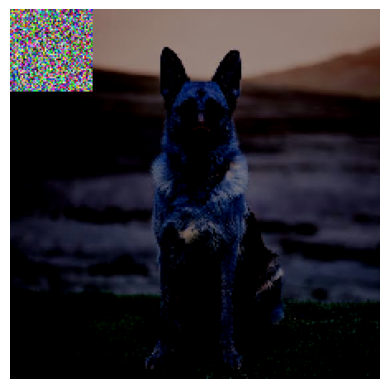

In [23]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Load VGG16 and VGG19 models (pre-trained on ImageNet)
vgg16_model = VGG16(weights='imagenet')

# Load ImageNet categories
categories = []
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Load and preprocess an image
def load_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return tf.convert_to_tensor(preprocess_input(img_array), dtype=tf.float32)  # Convert to TensorFlow tensor

# Apply adversarial patch to an image at a specified location
def apply_patch(image, patch, location):
    # Convert the image to a NumPy array for manipulation
    patched_image = image.numpy().copy()
    h, w, _ = patch.shape
    # Apply the patch at the specified location
    patched_image[:, location[0]:location[0]+h, location[1]:location[1]+w, :] = patch.numpy()
    return tf.convert_to_tensor(patched_image, dtype=tf.float32)  # Convert back to TensorFlow tensor

# Training the adversarial patch
def train_patch(model, image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05):
    image = load_image(image_path)
    
    # Initialize random patch with the required size as a trainable Variable
    patch = tf.Variable(tf.random.uniform((patch_size[0], patch_size[1], 3), minval=0, maxval=255), trainable=True, dtype=tf.float32)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    for step in range(num_steps):
        with tf.GradientTape() as tape:
            # Apply patch
            patched_image = apply_patch(image, patch, (0, 0))  # Place at the top-left corner
            
            # Forward pass through the model
            logits = model(patched_image)
            probabilities = tf.nn.softmax(logits[0])
            
            # Calculate loss to maximize the target class probability
            loss = -probabilities[target_class]
        
        # Compute gradients and update the patch
        gradients = tape.gradient(loss, [patch])
        if gradients[0] is not None:  # Ensure gradients are computed
            optimizer.apply_gradients(zip(gradients, [patch]))
        
        # Print training progress every 50 steps
        if step % 50 == 0:
            predicted_idx = tf.argmax(probabilities)
            predicted_label = categories[predicted_idx.numpy()]
            print(f"Step {step}, Loss: {loss.numpy():.4f}, Predicted label: {predicted_label}")

    return patch

# Display image with adversarial patch applied
def visualize_image(img):
    img = np.squeeze(img)
    plt.imshow(img.astype('uint8'))
    plt.axis('off')
    plt.show()

# Define the target class and train the patch on an example image
target_class = 129  # Example: Spoonbill
image_path = "german_shepard_dog.jpeg"  # Replace with your image path

# Train patch on VGG16
print("Training patch on VGG16 model...")
trained_patch_vgg16 = train_patch(vgg16_model, image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05)

# Save the trained adversarial patch
np.save("adversarial_patch_vgg16.npy", trained_patch_vgg16.numpy())

# Load image and apply the adversarial patch for evaluation
image = load_image(image_path)
patched_image_vgg16 = apply_patch(image, trained_patch_vgg16, (0, 0))

# Visualize the patched image
print("Evaluating patched image on VGG16...")
visualize_image(patched_image_vgg16)


In [29]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

# Load VGG16 and VGG19 models (pre-trained on ImageNet)
vgg16_model = models.vgg16(pretrained=True).eval()
vgg19_model = models.vgg19(pretrained=True).eval()

# Define the transformation for the input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the ImageNet categories
categories = []
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Load an example image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

def print_output_image(input_tensor, probabilities):
    visualize_image(input_tensor)
    # Read the categories
    with open("imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]
    # Show top categories per image
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())

def predict_output_vgg19_image(input_image):
    # Check if input is a PIL image or a tensor
    if isinstance(input_image, torch.Tensor):
        # If tensor, ensure it has shape [3, H, W] and add batch dimension
        input_tensor = input_image
        if input_tensor.dim() == 3:
            input_batch = input_tensor.unsqueeze(0)  # Add batch dimension
        elif input_tensor.dim() == 4:
            input_batch = input_tensor  # Already has batch dimension
        else:
            raise ValueError("Tensor input_image must have 3 or 4 dimensions (C, H, W) or (B, C, H, W)")
    else:
        # If it's a PIL Image, apply the preprocessing
        preprocess = transforms.Compose([
            transforms.Resize(299),
            transforms.CenterCrop(299),
            transforms.ToTensor(),
            # Uncomment if input images are not normalized
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        input_tensor = preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0)  # Add batch dimension
    
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        vgg19_model.to('cuda')
    
    with torch.no_grad():
      output = vgg19_model(input_batch)
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    print_output_image(input_tensor, probabilities)

        
def predict_output_vgg16_image(input_image):
    # Check if input is a PIL image or a tensor
    if isinstance(input_image, torch.Tensor):
        # If tensor, ensure it has shape [3, H, W] and add batch dimension
        input_tensor = input_image
        if input_tensor.dim() == 3:
            input_batch = input_tensor.unsqueeze(0)  # Add batch dimension
        elif input_tensor.dim() == 4:
            input_batch = input_tensor  # Already has batch dimension
        else:
            raise ValueError("Tensor input_image must have 3 or 4 dimensions (C, H, W) or (B, C, H, W)")
    else:
        # If it's a PIL Image, apply the preprocessing
        preprocess = transforms.Compose([
            transforms.Resize(299),
            transforms.CenterCrop(299),
            transforms.ToTensor(),
            # Uncomment if input images are not normalized
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        input_tensor = preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0)  # Add batch dimension
    
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        vgg16_model.to('cuda')
    
    with torch.no_grad():
      output = vgg16_model(input_batch)
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    print_output_image(input_tensor, probabilities)

# Apply the adversarial patch directly to the image
def apply_patch_direct(image, patch, location):
    patched_image = image.clone()
    h, w = patch.shape[1:3]
    patched_image[:, :, location[0]:location[0]+h, location[1]:location[1]+w] = patch
    return patched_image

# Train the adversarial patch
def train_patch(model, image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05):
    image = load_image(image_path).to(device)
    patch = torch.rand((3, *patch_size), requires_grad=True, device=device)
    optimizer = optim.Adam([patch], lr=lr)

    for step in range(num_steps):
        optimizer.zero_grad()
        
        # Apply the patch
        patched_image = apply_patch_direct(image, patch, (0, 0))  # Place at top-left corner
        
        # Forward pass through the model
        output = model(patched_image)
        probabilities = F.softmax(output, dim=1)
        
        # Loss to maximize the target class probability
        loss = -probabilities[0][target_class]
        loss.backward()
        
        # Update the patch
        optimizer.step()
        
        # Print progress
        if step % 50 == 0:
            _, predicted_idx = torch.max(probabilities, 1)
            predicted_label = categories[predicted_idx.item()]
            print(f"Step {step}, Loss: {loss.item():.4f}, Predicted label: {predicted_label}")

    return patch

# Visualize an image tensor
def visualize_image(tensor_image):
    img = tensor_image.clone().detach().cpu().squeeze()
    img = transforms.ToPILImage()(img)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Training patch on VGG16 model...
Step 0, Loss: -0.0000, Predicted label: German shepherd
Step 50, Loss: -0.9998, Predicted label: spoonbill
Step 100, Loss: -0.9999, Predicted label: spoonbill
Step 150, Loss: -1.0000, Predicted label: spoonbill
Step 200, Loss: -1.0000, Predicted label: spoonbill
Step 250, Loss: -1.0000, Predicted label: spoonbill
Step 300, Loss: -1.0000, Predicted label: spoonbill
Step 350, Loss: -1.0000, Predicted label: spoonbill
Step 400, Loss: -1.0000, Predicted label: spoonbill
Step 450, Loss: -1.0000, Predicted label: spoonbill
Evaluating patched image on VGG16...


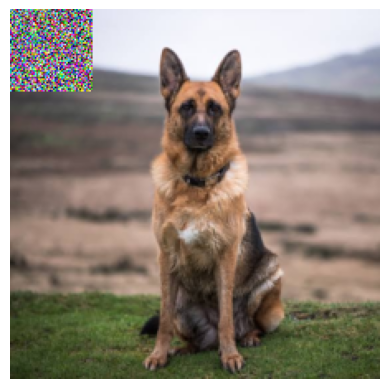

In [31]:
vgg16_model.to(device)

# Define the target class and train the patch on an example image
target_class = 129  # Example: Spoonbill
image_path = "german_shepard_dog.jpeg"  # Replace with your image path

# Train patch on VGG16
print("Training patch on VGG16 model...")
trained_patch_vgg16 = train_patch(vgg16_model, image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05)
torch.save(trained_patch_vgg16, "adversarial_patch_vgg16.pt")

# Load image and apply the adversarial patch for evaluation
image = load_image(image_path).to(device)

# Evaluate and visualize patched image for VGG16
print("Evaluating patched image on VGG16...")
patched_image_vgg16 = apply_patch_direct(image, trained_patch_vgg16, (0, 0))
visualize_image(patched_image_vgg16)

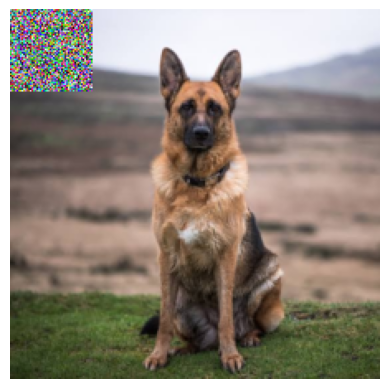

spoonbill 0.9999867677688599
flamingo 6.29368105364847e-06
American egret 2.260728479086538e-06
crane 1.195378558804805e-06
cock 9.606189905753126e-07


In [26]:
predict_output_vgg16_image(patched_image_vgg16)

Training patch on VGG19 model...
Step 0, Loss: -0.0000, Predicted label: German shepherd
Step 50, Loss: -0.0000, Predicted label: German shepherd
Step 100, Loss: -0.0001, Predicted label: malinois
Step 150, Loss: -0.9993, Predicted label: spoonbill
Step 200, Loss: -0.9997, Predicted label: spoonbill
Step 250, Loss: -0.9998, Predicted label: spoonbill
Step 300, Loss: -0.9999, Predicted label: spoonbill
Step 350, Loss: -0.9999, Predicted label: spoonbill
Step 400, Loss: -0.9999, Predicted label: spoonbill
Step 450, Loss: -0.9999, Predicted label: spoonbill
Evaluating patched image on VGG19...


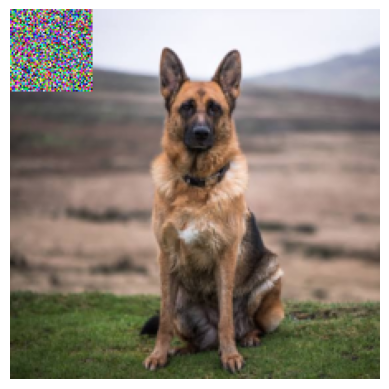

In [27]:
vgg19_model.to(device)

# Train patch on VGG19
print("Training patch on VGG19 model...")
trained_patch_vgg19 = train_patch(vgg19_model, image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05)
torch.save(trained_patch_vgg19, "adversarial_patch_vgg19.pt")

# Load image and apply the adversarial patch for evaluation
image = load_image(image_path).to(device)

# Evaluate and visualize patched image for VGG19
print("Evaluating patched image on VGG19...")
patched_image_vgg19 = apply_patch_direct(image, trained_patch_vgg19, (0, 0))
visualize_image(patched_image_vgg19)

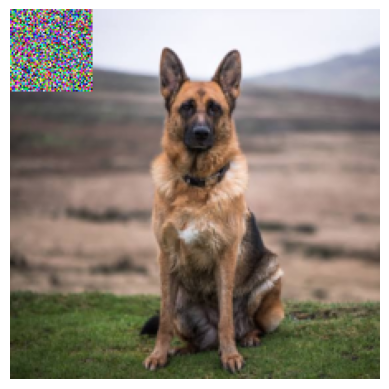

spoonbill 0.9999268054962158
white stork 2.9231643566163257e-05
pelican 2.2928779799258336e-05
American egret 8.541231181879994e-06
crane 6.21252092969371e-06


In [30]:
predict_output_vgg19_image(patched_image_vgg19)